# **Acne Analysis Model**

This project aims to develop a deep learning model capable of analyzing facial images to detect common skin conditions such as Blackheads, Cyst, Papules, Pustules, Whiteheads. The system not only identifies these conditions but also provides personalized recommendations for each detected issue, making it a helpful tool for users seeking insights into their skin health.

### **Import Modules**

In [24]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from io import BytesIO
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB1
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils import class_weight

### **Dataset Details**

In [4]:
TRAIN_DIR = '../input/Acne dataset/train/'
VAL_DIR = '../input/Acne dataset/valid/'
TEST_DIR = '../input/Acne dataset/test/'

### **Data Sample**

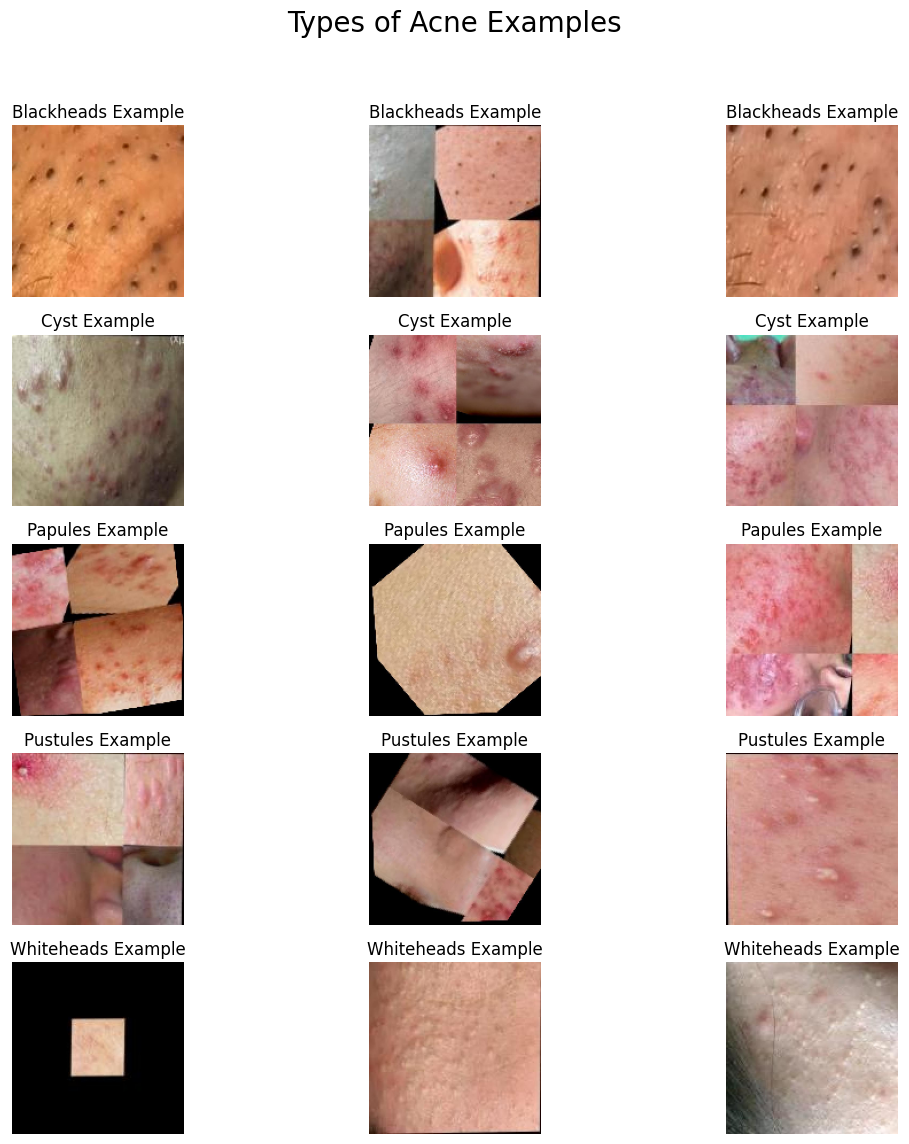

In [5]:
categories = ['Blackheads', 'Cyst', 'Papules', 'Pustules', 'Whiteheads']

fig, axes = plt.subplots(len(categories), 3 , figsize=(12, 12))
plt.suptitle("Types of Acne Examples", fontsize=20)

for i, category in enumerate(categories):
  category_path = os.path.join(TRAIN_DIR, category)
  images = os.listdir(category_path)[:3]
  for j, img_name in enumerate(images):
        img_path = os.path.join(category_path, img_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
        axes[i, j].imshow(img)
        axes[i, j].set_title(f'{category} Example')
        axes[i, j].axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [6]:
sample_array = tf.keras.preprocessing.image.img_to_array(img)
print(f"Each image has shape{sample_array.shape}")

Each image has shape(150, 150, 3)


In [7]:
sample_array[0,:5]

array([[165., 162., 155.],
       [160., 155., 149.],
       [170., 163., 157.],
       [176., 167., 162.],
       [171., 164., 158.]], dtype=float32)

### **Dataset Creation**

In [8]:
def train_val_test_dataset():

    train_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=TRAIN_DIR,
        batch_size=32,
        image_size=(150, 150),
        label_mode="categorical",
        shuffle=True
    )

    val_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=VAL_DIR,
        batch_size=32,
        image_size=(150, 150),
        label_mode="categorical",
    )
    
    test_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=TEST_DIR,
        batch_size=32,
        image_size=(150, 150),
        label_mode="categorical",
    )

    train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_dataset, val_dataset, test_dataset


In [9]:
train_dataset, val_dataset, test_dataset = train_val_test_dataset()
print(f"Images of train dataset have shape: {train_dataset.element_spec[0].shape}")
print(f"Labels of train dataset have shape: {train_dataset.element_spec[1].shape}")
print(f"Images of validation dataset have shape: {val_dataset.element_spec[0].shape}")
print(f"Labels of validation dataset have shape: {val_dataset.element_spec[1].shape}")

Found 2768 files belonging to 5 classes.
Found 921 files belonging to 5 classes.
Found 918 files belonging to 5 classes.
Images of train dataset have shape: (None, 150, 150, 3)
Labels of train dataset have shape: (None, 5)
Images of validation dataset have shape: (None, 150, 150, 3)
Labels of validation dataset have shape: (None, 5)


### **Data Augmentation**

In [10]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(height_factor=0.1),
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.2),
    layers.GaussianNoise(0.02),
    layers.Resizing(height=150, width=150)
])

### **Model Architecture**

In [11]:
def create_efficientnet_model():

    efficientnet_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(150, 150, 3)
    )

    for layer in efficientnet_model.layers[:-50]:
        layer.trainable = True

    input_layer = layers.Input(shape=(150, 150, 3))
    x = data_augmentation(input_layer)
    x = efficientnet_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.6)(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(5, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=True
    ),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
  )

    return model

### **Model Creation**

In [12]:
model = create_efficientnet_model()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
print(f"Input shape: {model.input_shape}")
print(f"Output shape: {model.output_shape}")

Input shape: (None, 150, 150, 3)
Output shape: (None, 5)


### **Model Defining**

In [14]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 5, 5, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,894,824 (22.49 MB)

 Trainable params: 5,849,729 (22.31 MB)

 Non-trainable params: 45,095 (176.16 KB)

In [15]:
example_batch_images, example_batch_labels = next(iter(train_dataset))

try:
    model.evaluate(example_batch_images, example_batch_labels, verbose=False)
except:
    print("Your model is not compatible with the dataset you defined earlier. Check that the loss function, last layer and label_mode are compatible with one another.")
else:
    predictions = model.predict(example_batch_images, verbose=False)
    print(f"predictions have shape: {predictions.shape}")

predictions have shape: (32, 5)


In [16]:
class_labels = []
for images, labels in train_dataset:
    class_labels.append(np.argmax(labels, axis=1))

class_labels = np.concatenate(class_labels)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)

class_weights = dict(enumerate(class_weights))
print(class_weights)


{0: 0.7531972789115646, 1: 0.8718110236220472, 2: 0.8914653784219002, 3: 0.947945205479452, 4: 2.8683937823834196}


### **Training**

In [17]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.8,
    patience=5,
    min_lr=1e-7,
    verbose=1
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

with tf.device('/GPU:0'):
    history = model.fit(
        train_dataset,
        epochs=60,
        validation_data=val_dataset,
        callbacks=[lr_scheduler, early_stopping],
        class_weight=class_weights
    )

Epoch 1/60
87/87 ━━━━━━━━━━━━━━━━━━━━ 65s 231ms/step - accuracy: 0.2540 - loss: 5.9967 - precision: 0.2702 - recall: 0.2001 - val_accuracy: 0.3811 - val_loss: 4.8648 - val_precision: 0.9286 - val_recall: 0.0282 - learning_rate: 1.0000e-04
Epoch 2/60
87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 182ms/step - accuracy: 0.3170 - loss: 5.3971 - precision: 0.3406 - recall: 0.2586 - val_accuracy: 0.4767 - val_loss: 4.6502 - val_precision: 0.7685 - val_recall: 0.1694 - learning_rate: 1.0000e-04
Epoch 3/60
87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 183ms/step - accuracy: 0.4114 - loss: 5.0537 - precision: 0.4509 - recall: 0.3498 - val_accuracy: 0.5147 - val_loss: 4.4974 - val_precision: 0.7126 - val_recall: 0.3257 - learning_rate: 1.0000e-04
Epoch 4/60
87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 182ms/step - accuracy: 0.4684 - loss: 4.8595 - precision: 0.5073 - recall: 0.4185 - val_accuracy: 0.5798 - val_loss: 4.3805 - val_precision: 0.7000 - val_recall: 0.4484 - learning_rate: 1.0000e-04
Epoch 5/60
87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 18

### **Evaluation**

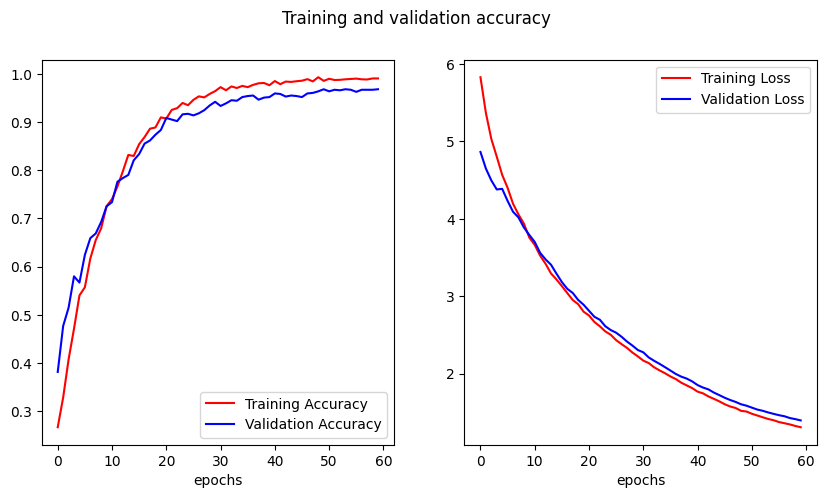

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

### **Test Metrics**

In [19]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss},\nTest Accuracy:: {test_accuracy},\nTest Precision:: {test_precision},\nTest Recall:: {test_recall}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9617 - loss: 1.4330 - precision: 0.9620 - recall: 0.9588
Test Loss: 1.4243834018707275,
Test Accuracy:: 0.9684095978736877,
Test Precision:: 0.970459520816803,
Test Recall:: 0.9662309288978577


### **Confusion Matrix**

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Test Set F1 Score: 0.9673848244523591


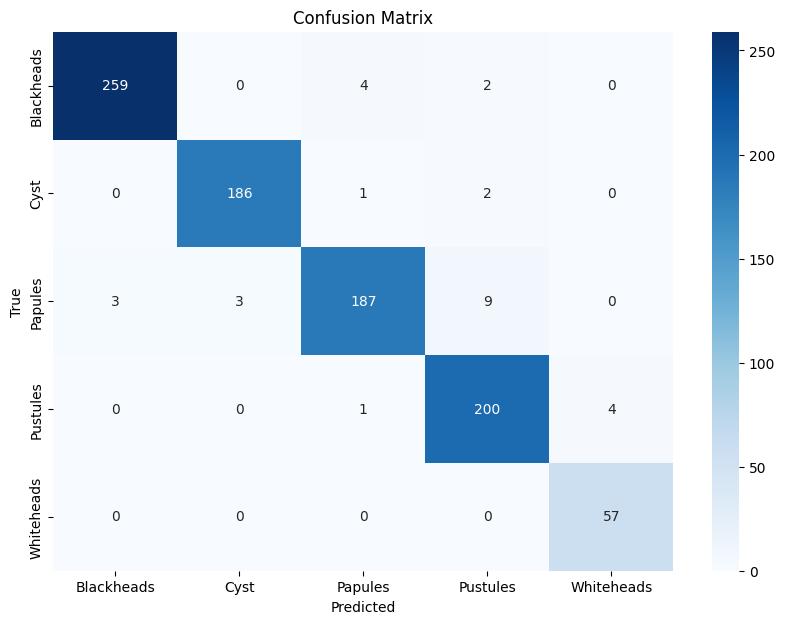

In [25]:
categories = categories

y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = np.argmax(model.predict(test_dataset), axis=1)

f1 = f1_score(np.argmax(y_true, axis=1), y_pred, average='macro')
print(f"Test Set F1 Score: {f1}")

cm = confusion_matrix(np.argmax(y_true, axis=1), y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


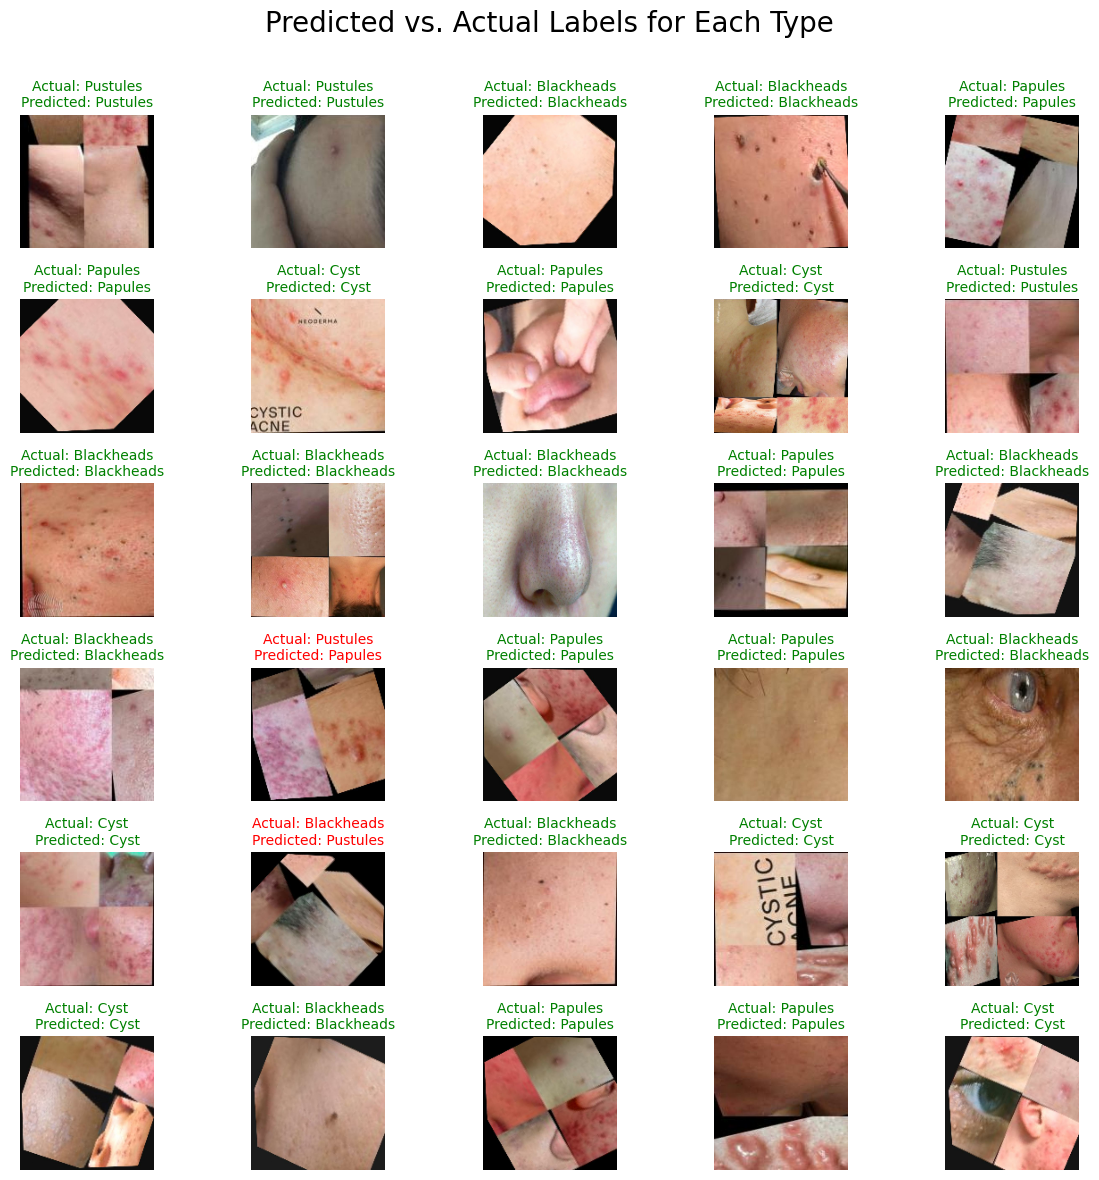

In [26]:
images, labels = next(iter(test_dataset))

predictions = model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)
actual_labels = np.argmax(labels, axis=1)


images = images / 255.0

fig, axes = plt.subplots(6, 5, figsize=(12, 12))
fig.suptitle("Predicted vs. Actual Labels for Each Type", fontsize=20)

for idx, ax in enumerate(axes.flat):
    if idx >= len(images):
        ax.axis('off')
        continue

    actual_category = categories[actual_labels[idx]]
    predicted_category = categories[predicted_labels[idx]]

    color = 'green' if actual_category == predicted_category else 'red'

    ax.imshow(images[idx].numpy().squeeze())
    ax.set_title(f"Actual: {actual_category}\nPredicted: {predicted_category}", fontsize=10, color=color)
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [27]:
def predict_custom_image(image_path, model, categories):

    try:
        img = Image.open(image_path)
        
        if img.mode != 'RGB':
            img = img.convert('RGB')

        img = img.resize((150, 150))

        img_array = tf.keras.preprocessing.image.img_to_array(img)

        img_array = np.expand_dims(img_array, axis=0)

        img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

        predictions = model.predict(img_array, verbose=0)

        top_3_indices = np.argsort(predictions[0])[-3:][::-1]
        print("\nTop 3 predictions:")
        for idx in top_3_indices:
            print(f"{categories[idx]}: {predictions[0][idx]:.2%}")
            
        predicted_class_index = np.argmax(predictions[0])
        confidence_score = float(predictions[0][predicted_class_index])
        
        return categories[predicted_class_index], confidence_score, img_array[0]
    
    except Exception as e:
        print(f"Error processing image: {str(e)}")
        return None, None, None

def display_prediction(image_path, model, categories):

    predicted_category, confidence_score, _ = predict_custom_image(image_path, model, categories)
    
    if predicted_category is not None:

        img = Image.open(image_path)
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {predicted_category}\nConfidence: {confidence_score:.2%}", 
                 fontsize=12, pad=20)
        plt.show()

        print(f"\nDetailed Analysis:")
        print(f"Predicted Category: {predicted_category}")
        print(f"Confidence Score: {confidence_score:.2%}")

### **Custom Prediction**


Top 3 predictions:
Pustules: 100.00%
Papules: 0.00%
Whiteheads: 0.00%


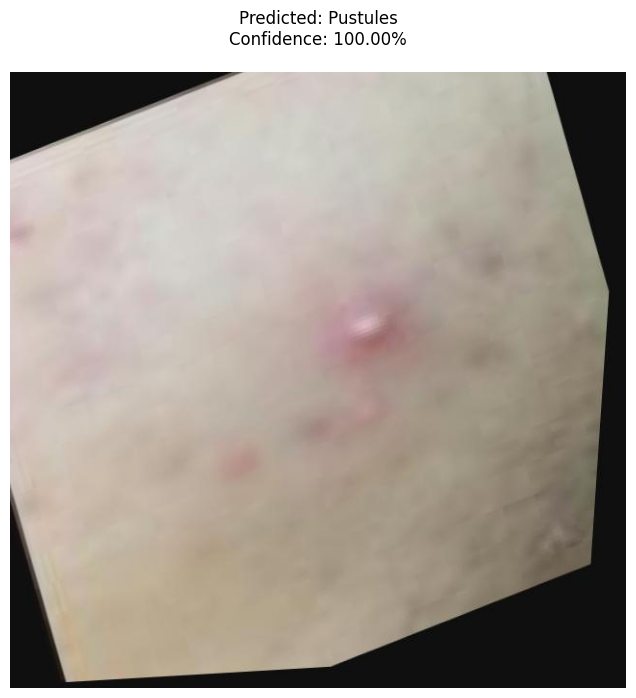


Detailed Analysis:
Predicted Category: Pustules
Confidence Score: 100.00%


In [35]:
image_path = '../input/Acne dataset/test/Pustules/Pustule-13-_jpg.rf.01286e97b6a5492d5b59d2779e9611af.jpg'

display_prediction(image_path, model, categories)


Top 3 predictions:
Whiteheads: 100.00%
Blackheads: 0.00%
Cyst: 0.00%


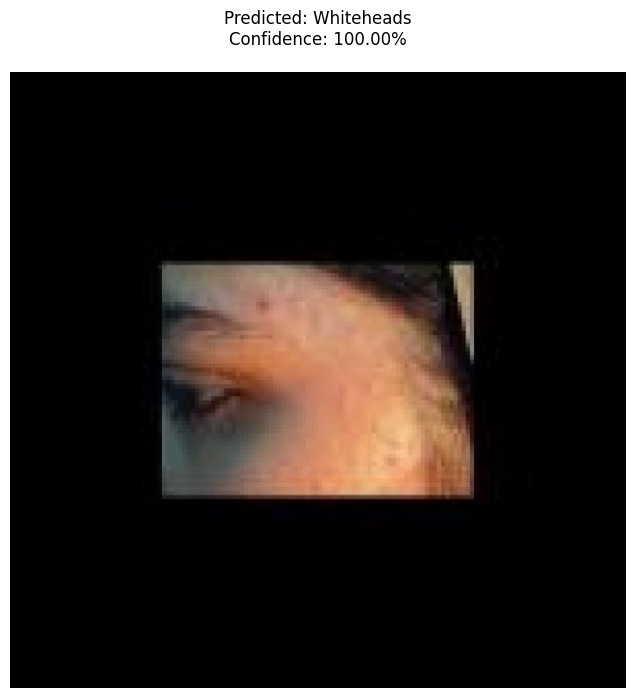


Detailed Analysis:
Predicted Category: Whiteheads
Confidence Score: 100.00%


In [36]:

image_path = "../input/Acne dataset/test/Whiteheads/white_head_-10-_jpg.rf.75e47f7e8e5b4dea5c6c9a106a1e96d0.jpg"

display_prediction(image_path, model, categories)

#### **Credits**

- Ansh Chauhan - Model creating
- Tushar Soni - Testing and Deployment
- Harshit Saini - Documentation